# Template for parsing pdf tables to data in bulk

## set up environment

*To run locally: create a conda environment*

On Windows, run on the Anaconda command prompt: 

`conda env create -f environment-exact-windows.yml`

which should load the exact, Windows-specific environment.

_If that fails, or on another system, run `conda env create -f environment.yml`. this may take a long, or even very long time to solve._

either way, when environment is loaded, run

`conda activate parse-pdf`

then run this notebook with that kernel.

In [1]:
import pandas as pd
import numpy as np
import camelot
import pypdf
import requests
from bs4 import BeautifulSoup
import re
import io
import warnings
from tqdm import tqdm


## load a sample 

In [2]:
# url to a sample pdf

url = 'https://hhinternet.blob.core.windows.net/uploads/2023/03/report-for-the-week-of-february-20-2023-to-february-26-2023.pdf'

In [3]:
# it will be easiest if you supply the page number to start (note the page number is as a string)
# below we'll go through how to find the page number from table text

table = camelot.read_pdf(
    url,
    pages='5',
    backend='poppler'
)

c:\Users\dlevine\Anaconda3\envs\parse-pdf-local-again-tqdm\lib\site-packages\camelot\utils.py:740: UserWarning:   (972.06, 974.54148) does not lie in column range (36.47998535156249, 971.76)
  warnings.warn(


In [4]:
table

# shows the number of tables parsed, should be the number of tables on the page

<TableList n=1>

The warning above warns that there is text on the page outside the area identified as the table. You can visually check the image parsing and see if it is working.  

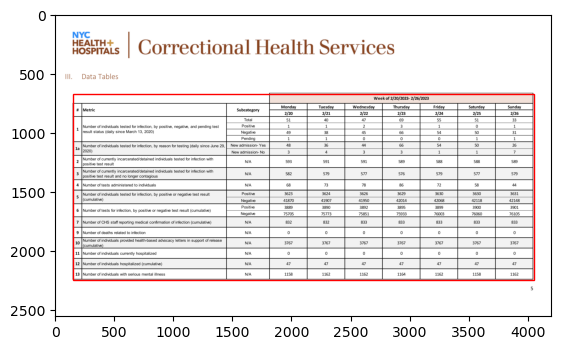

In [5]:
fig = camelot.plot(table[0], kind='contour')

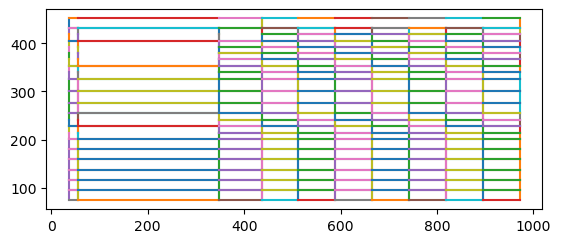

In [6]:
fig = camelot.plot(table[0], kind='grid')

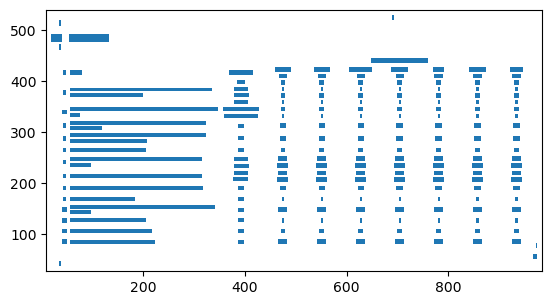

In [7]:
fig = camelot.plot(table[0], kind='text')

In [8]:
# since it is actually parsing the table just fine, we are going to supress that warning for now. careful doing this though.

warnings.filterwarnings('ignore',message='.* does not lie in column range')

### see how to parse it

This part has to be specific to the table you are working with. 

In [9]:
# see what you are working with

table[0].df

,0,1,2,3,4,5,6,7,8,9
0,,,,Week of 2/20/2023- 2/26/2023,,,,,,
1,#,Metric,Subcategory,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
2,,,,2/20,2/21,2/22,2/23,2/24,2/25,2/26
3,1,"Number of individuals tested for infection, by...",Total,51,40,47,69,55,51,33
4,,,Positive,1,1,2,3,1,0,1
5,,,Negative,49,38,45,66,54,50,31
6,,,Pending,1,1,0,0,0,1,1
7,1a,"Number of individuals tested for infection, by...",New admission- Yes,48,36,44,66,54,50,26
8,,,New admission- No,3,4,3,3,1,1,7
9,2,Number of currently incarcerated/detained indi...,N/A,593,591,591,589,588,588,589


string together pandas manipulations to get the data you want

In [10]:
# e.g. this to get the full table

    # select from row 1 down
data = (
    table[0].df
    .iloc[1:]
)

    # assign column names
data.columns = list(data.iloc[0,:3]) + list(data.iloc[1,3:])

    # drop rpws that had headings; fill down metric names
data = (
    data
    .drop(index=[1,2])
    .reset_index(drop=True)
    .replace('',np.nan)
    .ffill()
)

data

,#,Metric,Subcategory,2/20,2/21,2/22,2/23,2/24,2/25,2/26
0,1,"Number of individuals tested for infection, by...",Total,51,40,47,69,55,51,33
1,1,"Number of individuals tested for infection, by...",Positive,1,1,2,3,1,0,1
2,1,"Number of individuals tested for infection, by...",Negative,49,38,45,66,54,50,31
3,1,"Number of individuals tested for infection, by...",Pending,1,1,0,0,0,1,1
4,1a,"Number of individuals tested for infection, by...",New admission- Yes,48,36,44,66,54,50,26
5,1a,"Number of individuals tested for infection, by...",New admission- No,3,4,3,3,1,1,7
6,2,Number of currently incarcerated/detained indi...,N/A,593,591,591,589,588,588,589
7,3,Number of currently incarcerated/detained indi...,N/A,582,579,577,576,579,577,579
8,4,Number of tests administered to individuals,N/A,68,73,78,86,72,58,44
9,5,"Number of individuals tested for infection, by...",Positive,3623,3624,3626,3629,3630,3630,3631


In [11]:
# or more usefully, this to get just the data you need

In [12]:
# get the row of data

data = (
    table[0].df
    .iloc[21, -7:]
    .astype(int)
)

# find the week end date by 
#   searching for numbers in the first row of the table (where the dates of the week are) 
#   and creating a date object from the second date (end of week)

week_end_date = pd.to_datetime('-'.join(table[0].df.iloc[0].str.findall(r'\d+').max()[-3:]))

# check that the parsed date is a Sunday

assert week_end_date.day_of_week == 6, "error parsing the week end date"

# and then create a seven-day index from that

week_daterange = pd.date_range(end=week_end_date, periods=7, freq='D')

# and set the day index

data = data.set_axis(week_daterange)

data

2023-02-20    1158
2023-02-21    1162
2023-02-22    1162
2023-02-23    1164
2023-02-24    1162
2023-02-25    1158
2023-02-26    1162
Freq: D, Name: 21, dtype: int32

Because this and many tables in the wild are formatted with different levels of headings and columns, it's going to take some careful parsing to get the data you need. 

You'll probably need to use `.iloc` absolute references to arbitrary row and column indexes, but do be careful because if the format of the table changes, these absolute references will get thrown off. (like this fine specimen where the metric numbers are missing so the columns are all shifted left one: https://hhinternet.blob.core.windows.net/uploads/2022/07/report-for-the-week-of-june-20-2022-to-june-26-2022.pdf)

This example has all the data we need (the date and measure value) within the table, it just takes some searching and manipulation _of the table_ to get it. For other cases, you may need to get the date or labels from elsewhere in the pdf or from the file name.  See below for other ways to get that.

### Make a parsing function

Create a custom `Exception` to catch anomolies where the data parsed is not what it should be. These should catch instances where the data munging grabs the wrong part of the table or something is amiss in the source data. These tests can check the data values (as here), or types, or some other check. It's easiest of you can set some reasonable thresholds/guardrails from the outset, but you could also build up tests from the data, e.g. from the mean of previous weeks.

This will raise an error, which by default will make the function stop on an error, but that is what we want for now. You'll likely need to refine this parsing function to make sure it handles all the actual tables correctly. When we loop through everything we'll warn on these errors to be able to check the failing instances.

In [13]:
# create a custom exceptions classes for catching errors

class ParseError(Exception):
    '''parsed data were not what they were expected to be'''

def parse_data(df):

    df = df.copy()

    data = (
        df
        .iloc[21, -7:]
        .astype(int)
        .rename('Number of individuals with serious mental illness')
    )

    # check that the data is plausible

    if data.min() < 200 or data.max() > 2000:
        raise ParseError("parsed data values seem out of usual range")

    # find the week date by searching for numbers in the first row of the table (where the dates of the week are) 
    # and creating a date object from the second date (end of week)

    week_end_date = pd.to_datetime('-'.join(df.iloc[0].str.findall(r'\d+').max()[-3:]))

    # check that the parsed date is a Sunday

    if week_end_date.day_of_week != 6:
        raise ParseError("error parsing the week end date")

    # and then create a seven-day index from that

    week_daterange = pd.date_range(end=week_end_date, periods=7, freq='D')

    # and set the day index

    data = data.set_axis(week_daterange)

    return data
    

## Get paths to all files

find the links on the webpage and filter to just the ones you need

In [14]:
# page with the links to pdf reports

page_with_links_url = 'https://www.nychealthandhospitals.org/correctionalhealthservices/publications-reports/'

In [15]:
# get and parse that page

r = requests.get(page_with_links_url, verify=False)
html_page = r.text
soup = BeautifulSoup(html_page, 'html.parser')

c:\Users\dlevine\Anaconda3\envs\parse-pdf-local-again-tqdm\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.nychealthandhospitals.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


now add filter conditions to find the specific pdf links you are loooking for. 

(You can run this first getting _all_ pdf files and inspect the link text to find what you are looking for)

In [16]:
target_files = []

anchors = soup.find_all('a')

for a in anchors:
    a_href = a.get('href')
    if (
        isinstance(a_href,str) and 
        len(a_href) > 3 and 
        a_href[-3:] == 'pdf' and  # these first three filters will return all links to `.pdf` files
        'report-for-the-week-of-' in a_href # add any additional conditions to get just the paths to the reports you need
    ):
        target_files.append(a_href)

target_files

['https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-may-1-2023-to-may-7-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-april-24-2023-to-april-30-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-april-17-2023-to-april-23-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-april-10-2023-to-april-16-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-april-3-2023-to-april-9-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-march-27-2023-to-april-2-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-march-20-2023-to-march-26-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-march-13-2023-to-march-19-2023.pdf',
 'https://hhinternet.blob.core.windows.net/uploads/2023/0

these links are all absolute (beginning with `http://`), but you may find relative links, too.

you can prepend the root url with 

```py
import urllib

base_url = 'https://www.nyc.gov' # or whatever the root is

absolute_targets = [base_url + urllib.parse.quote(target) for target in target_files]
```

## loop and parse all

ok! party time. Go through all the files, extract the data, and concat it all together.

Note this is there you are going to find surprise errors when there are pdfs, tables, file names etc that don't exactly conform to your samples.

So use the error messages to see which files are causing problems and go back and adjust the functions accordingly. Doing this iteratively in a notebook is going to be the way to go until you are sure you are capturing what you need.

First, another function to page through the pdf to find the page with the table we need:

In [17]:
class TextNotFoundError(ParseError):
    'search pattern is not found in pdf'

def find_page_number(target, search_pattern="Number of individuals with serious mental illness"):
    '''
    find what page the table with the search pattern is on.
    (return the _last_ page with the search pattern in the pdf)
    (with this pdf open you could also extract other information from the text as above)
    '''

    r = requests.get(target)

    pdf_object = io.BytesIO(r.content)

    reader = pypdf.PdfReader(stream=pdf_object)

    total_pages = len(reader.pages)

    for page_number in range(total_pages-1,-1,-1):  # search from last page to first (zero-indexed)
        page_object = reader.pages[page_number]
        page_text = page_object.extract_text()
        
        if re.search(search_pattern,page_text):
            return page_number + 1    # +1 because these pages are zero-indexed 

    raise TextNotFoundError

Loop through the files, try to find the table and parse the table, otherwise raise warnings.

the `except`, `warn`, `continue` signature will catch an error, warn that an error was encountered, and then continue to the next file.

You should investigate these error-throwing files.

In some cases, the data you want is not available. (e.g. this anomalous week  https://hhinternet.blob.core.windows.net/uploads/2022/09/report-for-the-week-of-august-8-2022-to-august-14-2022.pdf). Sad. 

In other cases there will be some variation that the functions above are not able to handle. Either modify the functions above to to handle these situations, or, if that is not possible or really too much trouble, note the issues and manually correct the data (e.g. copy and paste into your final output). 

In [18]:
all_weeks_data_list = []

search_text = "Number of individuals with serious mental illness"

for target in tqdm(target_files):

    try:
        table_page_number = find_page_number(target)

    except TextNotFoundError:
        warnings.warn(f"text not found in pdf from {target}")
        continue
    
    table = camelot.read_pdf(
        target, 
        pages=str(table_page_number),
        backend='poppler'
    )
    
    try:
        week_data = parse_data(table[0].df)

    except ParseError as e:
        warnings.warn(f"error extracting table from {target}): {e}")

        continue

    all_weeks_data_list.append(week_data)

all_weeks_data = pd.concat(all_weeks_data_list)

 24%|██▍       | 35/146 [02:06<08:18,  4.49s/it]C:\Users\dlevine\AppData\Local\Temp\ipykernel_6952\23434817.py:11: UserWarning: text not found in pdf from https://hhinternet.blob.core.windows.net/uploads/2022/09/report-for-the-week-of-august-8-2022-to-august-14-2022.pdf
  warnings.warn(f"text not found in pdf from {target}")
100%|██████████| 146/146 [08:05<00:00,  3.33s/it]


In [19]:
all_weeks_data

2023-05-01    1209
2023-05-02    1217
2023-05-03    1219
2023-05-04    1214
2023-05-05    1213
              ... 
2020-07-01     664
2020-07-02     663
2020-07-03     659
2020-07-04     657
2020-07-05     661
Name: Number of individuals with serious mental illness, Length: 1015, dtype: int32

### Check (and correct) the extracted data

A few more checks on the data before we call it success.

Check for duplicate index values.

In [20]:
all_weeks_data.index.duplicated().any()

True

In [21]:
all_weeks_data[all_weeks_data.index.duplicated(keep=False)].sort_index()

2022-06-20     972
2022-06-20     972
2022-06-21     977
2022-06-21     977
2022-06-22     983
2022-06-22     983
2022-06-23     986
2022-06-23     986
2022-06-24     985
2022-06-24     985
2022-06-25     980
2022-06-25     980
2022-06-26     979
2022-06-26     979
2022-10-10    1079
2022-10-10    1079
2022-10-11    1083
2022-10-11    1083
2022-10-12    1078
2022-10-12    1078
2022-10-13    1071
2022-10-13    1071
2022-10-14    1071
2022-10-14    1071
2022-10-15    1068
2022-10-15    1068
2022-10-16    1077
2022-10-16    1077
Name: Number of individuals with serious mental illness, dtype: int32

we got a few weeks twice, but at least the numbers extracted are the same in each instance

note, though, that's a problem with the source data (check the site), not a problem in the program. but we need to handle it.

In [22]:
all_weeks_data_dedup = (
    all_weeks_data
    .sort_index()
    .reset_index()
    .drop_duplicates(subset='index')
    .rename(columns={'index':'Date'})
    .set_index('Date')
)

all_weeks_data_dedup

,Number of individuals with serious mental illness
Date,
2020-06-29,669
2020-06-30,664
2020-07-01,664
2020-07-02,663
2020-07-03,659
...,...
2023-05-03,1219
2023-05-04,1214
2023-05-05,1213


Also check for what dates are _missing_ data.

The parser warned about one week where the data was missing from the report, but there may be other weeks missing reports entirely.

In [23]:
full_index = pd.date_range(all_weeks_data.index.min(),all_weeks_data.index.max(), inclusive='both')

In [24]:
full_index[~full_index.isin(all_weeks_data.index)]

# dates missing from the parsed data

DatetimeIndex(['2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-09', '2022-07-10', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-13', '2022-08-14', '2022-10-17', '2022-10-18',
               '2022-10-19', '2022-10-20', '2022-10-21', '2022-10-22',
               '2022-10-23', '2022-10-24', '2022-10-25', '2022-10-26',
               '2022-10-27', '2022-10-28', '2022-10-29', '2022-10-30',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31', '2023-01-01', '2023-03-06',
               '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10',
               '2023-03-11', '2023-03-12'],
              dtype='datetime64[ns]', freq=None)

In [25]:
full_index_weeks = pd.date_range(all_weeks_data.index.min(),all_weeks_data.index.max(), inclusive='both', freq='W')

full_index_weeks[~full_index_weeks.isin(all_weeks_data.index)]

# weeks missing from the parsed data (Sunday dates)

DatetimeIndex(['2022-07-10', '2022-08-14', '2022-10-23', '2022-10-30',
               '2023-01-01', '2023-03-12'],
              dtype='datetime64[ns]', freq=None)

Of course add additional relevant checks on the data here, too. 

And since what we really want is month data, you can easily reaggregate the daily values to monthly

In [26]:
(
    all_weeks_data_dedup
    .resample('M')
    .mean()
)

# note this will skip/ignore NaN values

,Number of individuals with serious mental illness
Date,
2020-06-30,666.500000
2020-07-31,671.806452
2020-08-31,679.322581
2020-09-30,727.233333
2020-10-31,756.354839
2020-11-30,756.166667
2020-12-31,783.645161
2021-01-31,825.806452
2021-02-28,847.857143


In [27]:
# or whatever other aggregation you need e.g.

(
    all_weeks_data_dedup
    .resample('M')
    .agg(['mean', 'median','sum','max'])
)

Number of individuals with serious mental illness                 \
                                                        mean  median    sum   
Date                                                                          
2020-06-30                                        666.500000   666.5   1333   
2020-07-31                                        671.806452   671.0  20826   
2020-08-31                                        679.322581   679.0  21059   
2020-09-30                                        727.233333   727.0  21817   
2020-10-31                                        756.354839   756.0  23447   
2020-11-30                                        756.166667   755.5  22685   
2020-12-31                                        783.645161   784.0  24293   
2021-01-31                                        825.806452   825.0  25600   
2021-02-28                                        847.857143   843.5  23740   
2021-03-31                                        895.870968   891.0  27772   
2021-04-30                                        954.766667   957.0  28643   
2021-05-31                                        960.096774   955.0  29763   
2021-06-30                                        952.700000   953.0  28581   
2021-07-31                                        957.645161   958.0  29687   
2021-08-31                                        957.032258   957.0  29668   
2021-09-30                                        921.933333   929.0  27658   
2021-10-31                                        872.354839   872.0  27043   
2021-11-30                                        854.333333   854.5  25630   
2021-12-31                                        842.838710   842.0  26128   
2022-01-31                                        852.870968   842.0  26439   
2022-02-28                                        886.178571   885.5  24813   
2022-03-31                                        905.483871   906.0  28070   
2022-04-30                                        912.900000   916.0  27387   
2022-05-31                                        926.129032   926.0  28710   
2022-06-30                                        961.233333   966.0  28837   
2022-07-31                                       1002.833333  1002.5  24068   
2022-08-31                                       1032.833333  1033.0  24788   
2022-09-30                                       1061.066667  1062.5  31832   
2022-10-31                                       1075.117647  1075.0  18277   
2022-11-30                                       1107.733333  1106.0  33232   
2022-12-31                                       1112.800000  1114.0  27820   
2023-01-31                                       1153.033333  1154.0  34591   
2023-02-28                                       1163.964286  1165.0  32591   
2023-03-31                                       1159.500000  1163.5  27828   
2023-04-30                                       1186.166667  1188.5  35585   
2023-05-31                                       1210.000000  1213.0   8470   

                  
             max  
Date              
2020-06-30   669  
2020-07-31   690  
2020-08-31   692  
2020-09-30   753  
2020-10-31   775  
2020-11-30   768  
2020-12-31   805  
2021-01-31   842  
2021-02-28   876  
2021-03-31   930  
2021-04-30   978  
2021-05-31   978  
2021-06-30   964  
2021-07-31   975  
2021-08-31   975  
2021-09-30   962  
2021-10-31   890  
2021-11-30   874  
2021-12-31   863  
2022-01-31   881  
2022-02-28   903  
2022-03-31   925  
2022-04-30   927  
2022-05-31   935  
2022-06-30   986  
2022-07-31  1023  
2022-08-31  1049  
2022-09-30  1084  
2022-10-31  1120  
2022-11-30  1132  
2022-12-31  1125  
2023-01-31  1186  
2023-02-28  1184  
2023-03-31  1178  
2023-04-30  1202  
2023-05-31  1219

and check difference from the previous month

In [28]:
month_mean = (
    all_weeks_data_dedup
    .resample('M')
    .mean()
)

month_mean['absoulte change'] = month_mean['Number of individuals with serious mental illness'].diff()
month_mean['pct change'] = month_mean['Number of individuals with serious mental illness'].pct_change()

month_mean

,Number of individuals with serious mental illness,absoulte change,pct change
Date,,,
2020-06-30,666.500000,NaN,NaN
2020-07-31,671.806452,5.306452,0.007962
2020-08-31,679.322581,7.516129,0.011188
2020-09-30,727.233333,47.910753,0.070527
2020-10-31,756.354839,29.121505,0.040044
2020-11-30,756.166667,-0.188172,-0.000249
2020-12-31,783.645161,27.478495,0.036339
2021-01-31,825.806452,42.161290,0.053802
2021-02-28,847.857143,22.050691,0.026702


Finally, save out the data you need 

In [29]:
# month_mean.to_csv('output_file.csv')

---

## Appendix: other ways to get dates of labels

In this example, all the data we needed was in the table. But in other cases you may need to get a date or label from the file name or from some other text in the file. Here are some other ways to do that. 

If you are sure the files are in order and at a regular cadance you can create an index.

This doesn't apply for this example but for another example with quarterly files, this could work:

```py
date_target = {date:target for date, target in zip([f'{year}-Q{q}' for year in range(2017, 2023) for q in range(1,5)][:-2],quarter_files)}
```

if you're sure they follow a consistent pattern you can parse the text with string manipulations, something like this

In [30]:
def parse_date_from_file_name(file):

    return ' '.join(
        file
        .split('report-for-the-week-of-')
        [-1]
        .rstrip('.pdf')
        .replace('-',' ')
        .title()
        .split()
        [-3:]
    )

In [31]:
date_targets = {parse_date_from_file_name(file):file for file in target_files}

date_targets

{'May 7 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-may-1-2023-to-may-7-2023.pdf',
 'April 30 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-april-24-2023-to-april-30-2023.pdf',
 'April 23 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-april-17-2023-to-april-23-2023.pdf',
 'April 16 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-april-10-2023-to-april-16-2023.pdf',
 'April 9 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-april-3-2023-to-april-9-2023.pdf',
 'April 2 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-march-27-2023-to-april-2-2023.pdf',
 'March 26 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-march-20-2023-to-march-26-2023.pdf',
 'March 19 2023': 'https://hhinternet.blob.core.windows.net/up

but be careful because atypical file names will throw this off

In [32]:
list(date_targets.keys())[96:103]

['June 6 2021',
 'May 30 2021',
 'May 23 2021',
 'May 16 2021',
 'May 9 2021',
 'May 2 2021',
 'April 25 2021']

a careful regex search might do better.

In [33]:
def regex_parse_date_from_file_name(file):

    month = re.findall('(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)', file)[-1].title()

    day = re.findall('\-\d+\-',file)[-1].strip('-')

    year = re.findall('\-20\d+',file)[-1].strip('-')

    return ' '.join([month, day, year])

In [34]:
date_targets = {regex_parse_date_from_file_name(file):file for file in target_files}

date_targets

{'May 7 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-may-1-2023-to-may-7-2023.pdf',
 'Apr 30 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-april-24-2023-to-april-30-2023.pdf',
 'Apr 23 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-april-17-2023-to-april-23-2023.pdf',
 'Apr 16 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-april-10-2023-to-april-16-2023.pdf',
 'Apr 9 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-april-3-2023-to-april-9-2023.pdf',
 'Apr 2 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/05/report-for-the-week-of-march-27-2023-to-april-2-2023.pdf',
 'Mar 26 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/04/report-for-the-week-of-march-20-2023-to-march-26-2023.pdf',
 'Mar 19 2023': 'https://hhinternet.blob.core.windows.net/uploads/2023/04/

if you're counting on these dates, it's probably a good idea to add an `assert` check in here, too.

### parse dates or labels from file contents

instead of the file slugs, you can also extract date or label text from the text of the pdf report.

In [35]:
sample_target = date_targets['Jul 11 2021']
sample_target

'https://hhinternet.blob.core.windows.net/uploads/2021/07/report-for-the-week-of-july-05-2021-to-july-11-2021.pdf'

In [36]:
# get page, open pdf, get title page text

r = requests.get(sample_target)

pdf_object = io.BytesIO(r.content)

reader = pypdf.PdfReader(stream=pdf_object)

first_page = reader.pages[0]

first_page_text = first_page.extract_text()

# find months, days, years. select the last one.

month = re.findall('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)', first_page_text)[-1].title()

day = re.findall('\ \d+\,',first_page_text)[-1].strip(', ')

year = re.findall('20\d+',first_page_text)[-1]

# combine to a date object

print('-'.join([month,day,year]))

end_of_week_date = pd.to_datetime('-'.join([month,day,year]))

print(end_of_week_date)

Jul-11-2021
2021-07-11 00:00:00
